# Pedestrian Speed 
Comparison between traditional physics-based and modern data-driven approaches for predicting pedestrian speed.



## 1. Import



In [2]:
# Import with module reload to get latest changes
import importlib
import utils

importlib.reload(utils)
from utils import *

import os
import numpy as np
import pandas as pd

## 2. Data paths and configs

Set up data paths. For now, we are only using one dataset

In [3]:
corridor_folder = "Corridor_data"
corridor_list = [
    "ug-180-015.txt",
    "ug-180-030.txt",
    "ug-180-060.txt",
    "ug-180-085.txt",
    "ug-180-095.txt",
    "ug-180-110.txt",
    "ug-180-140.txt",
    "ug-180-230.txt",
]

bottleneck_folder = "Bottleneck_data"
bottleneck_data_files = [
    "uo-180-070.txt",
    "uo-180-095.txt",
    "uo-180-120.txt",
    "uo-180-180.txt",
]


# Initialize data storage
bottleneck_data_list = []

# Set up data paths
base_path = os.path.join("..", "data", "Corridor_Data")
file_path = os.path.join(base_path, "ug-180-140.txt")

print(f"Data file path: {file_path}")
print(f"File exists: {os.path.exists(file_path)}")

Data file path: ..\data\Corridor_Data\ug-180-140.txt
File exists: True


## 3. Load and Process Bottleneck Data

Read the bottleneck data file using pandas, set appropriate column names, and prepare the dataframe for processing. <br> 
* Loads pedestrian trajectory data <br> 
* Each row = one person's position at one time frame <br> 
* Columns: pedestrian ID, time frame, x/y/z coordinates <br> 

In [4]:
# Helper function to load, process each file individually, and concatenate processed results
def load_and_concat_processed(folder, file_list, max_neighbors=10):
    """
    Load files one by one, process each with process_dataset, and concatenate the processed results
    Returns: (combined_weidmann_data, combined_nn_data)
    """
    weidmann_results = []
    nn_results = []

    for fname in file_list:
        fpath = os.path.join("..", "data", folder, fname)
        if os.path.exists(fpath):
            print(f"Processing file: {fname}")

            # Load individual file
            df_tmp = pd.read_csv(fpath, sep="\s+", header=None)
            df_tmp = df_tmp.set_axis(["id", "frame", "x", "y", "z"], axis=1)
            df_tmp[["x", "y", "z"]] = df_tmp[["x", "y", "z"]] / 100

            # Process this file with process_dataset
            try:
                file_weidmann, file_nn = process_dataset(df_tmp, max_neighbors)
                weidmann_results.extend(file_weidmann)
                nn_results.extend(file_nn)
                print(
                    f"  - Processed {len(file_weidmann)} Weidmann samples, {len(file_nn)} NN samples"
                )
            except Exception as e:
                print(f"  - Error processing {fname}: {e}")
        else:
            print(f"File not found: {fpath}")

    print(
        f"Total processed samples: {len(weidmann_results)} Weidmann, {len(nn_results)} NN"
    )
    return weidmann_results, nn_results


# Load and process corridor data file by file
print("=== Processing Corridor Data ===")
dataset_corridor_weidmann, dataset_corridor_nn = load_and_concat_processed(
    "Corridor_data", corridor_list, 10
)

# Load and process bottleneck data file by file
print("\n=== Processing Bottleneck Data ===")
dataset_bottleneck_weidmann, dataset_bottleneck_nn = load_and_concat_processed(
    "Bottleneck_data", bottleneck_data_files, 10
)

=== Processing Corridor Data ===
Processing file: ug-180-015.txt
  - Processed 0 Weidmann samples, 0 NN samples
Processing file: ug-180-030.txt
  - Error processing ug-180-030.txt: index 7 is out of bounds for axis 0 with size 7
Processing file: ug-180-060.txt
  - Processed 38461 Weidmann samples, 38461 NN samples
Processing file: ug-180-085.txt
  - Processed 52940 Weidmann samples, 52940 NN samples
Processing file: ug-180-095.txt
  - Processed 151708 Weidmann samples, 151708 NN samples
Processing file: ug-180-110.txt
  - Processed 112932 Weidmann samples, 112932 NN samples
Processing file: ug-180-140.txt
  - Error processing ug-180-140.txt: index 10 is out of bounds for axis 0 with size 10
Processing file: ug-180-230.txt
  - Processed 202795 Weidmann samples, 202795 NN samples
Total processed samples: 558836 Weidmann, 558836 NN

=== Processing Bottleneck Data ===
Processing file: uo-180-070.txt
  - Processed 74313 Weidmann samples, 74313 NN samples
Processing file: uo-180-095.txt
  - 

In [5]:
weidmann_bottleneck_df = pd.DataFrame(dataset_bottleneck_weidmann)
# weidmann_df = weidmann_df / 100
nn_bottleneck_df = pd.DataFrame(dataset_bottleneck_nn)

weidmann_corridor_df = pd.DataFrame(dataset_corridor_weidmann)
nn_corridor_df = pd.DataFrame(dataset_corridor_nn)


print("\nWeidmann dataset sample:")
print(weidmann_bottleneck_df.head())


Weidmann dataset sample:
          0         1
0  3.491044  2.151262
1  3.707717  2.331259
2  2.918338  2.150672
3  2.048753  1.355768
4  2.239282  1.664815


## 4. Data Analysis and Visualization

Analyze the processed datasets to understand the relationship between spacing and speed, and visualize the fundamental diagram.

* Creates the fundamental diagram: scatter plot of spacing vs speed
* Shows basic statistics of the data
* Calculates correlation between spacing and speed
* This reveals the core relationship: more space = higher walking speed

=== Dataset Statistics ===
BOTTLENECK DATA:
  Number of observations: 250641
  Spacing - Mean: 1.100, Std: 0.386
  Speed - Mean: 0.643, Std: 0.336
  Speed range: [0.006, 2.651]

CORRIDOR DATA:
  Number of observations: 558836
  Spacing - Mean: 1.172, Std: 0.497
  Speed - Mean: 0.432, Std: 0.345
  Speed range: [0.000, 2.231]


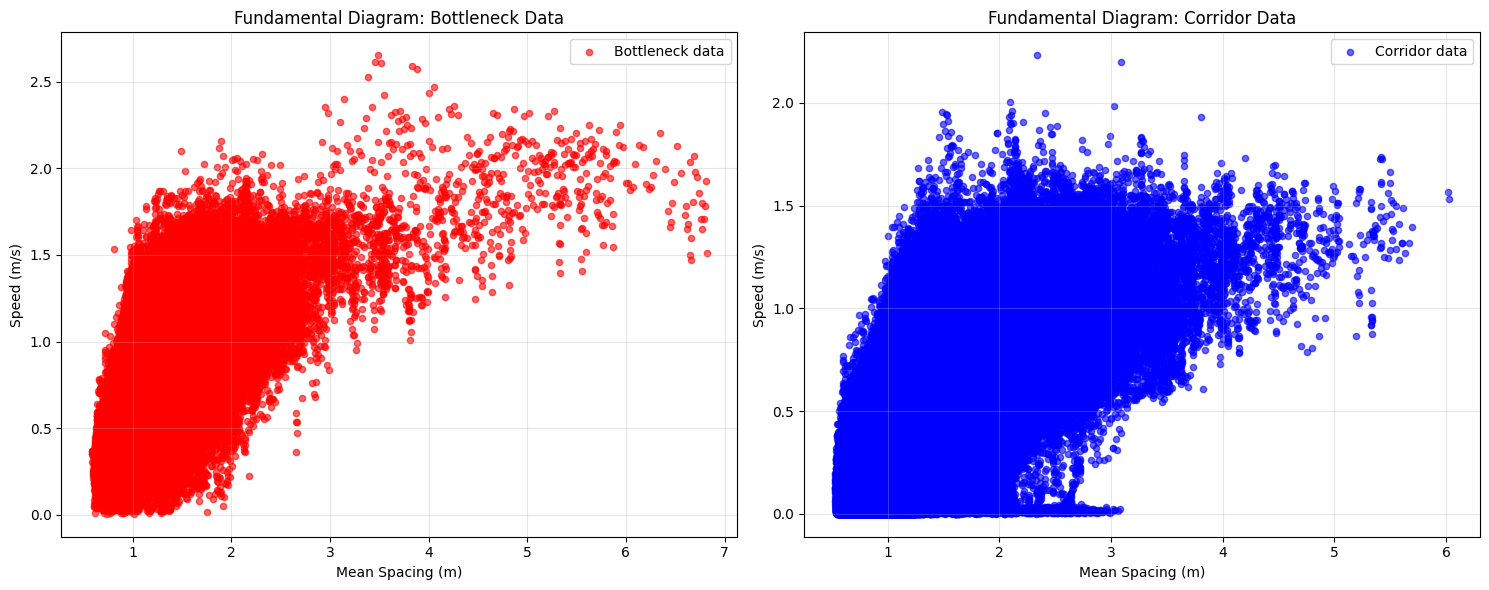


Correlation between spacing and speed:
  Bottleneck: 0.684
  Corridor: 0.693


In [6]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Prepare the data for analysis - Bottleneck data
bottleneck_data = np.array(weidmann_bottleneck_df)
spacing_bottleneck = bottleneck_data[:, 0]  # mean spacing
speed_bottleneck = bottleneck_data[:, 1]  # observed speed

# Prepare the data for analysis - Corridor data
corridor_data = np.array(weidmann_corridor_df)
spacing_corridor = corridor_data[:, 0]  # mean spacing
speed_corridor = corridor_data[:, 1]  # observed speed

# Basic statistics for both datasets
print("=== Dataset Statistics ===")
print("BOTTLENECK DATA:")
print(f"  Number of observations: {len(spacing_bottleneck)}")
print(
    f"  Spacing - Mean: {np.mean(spacing_bottleneck):.3f}, Std: {np.std(spacing_bottleneck):.3f}"
)
print(
    f"  Speed - Mean: {np.mean(speed_bottleneck):.3f}, Std: {np.std(speed_bottleneck):.3f}"
)
print(
    f"  Speed range: [{np.min(speed_bottleneck):.3f}, {np.max(speed_bottleneck):.3f}]"
)

print("\nCORRIDOR DATA:")
print(f"  Number of observations: {len(spacing_corridor)}")
print(
    f"  Spacing - Mean: {np.mean(spacing_corridor):.3f}, Std: {np.std(spacing_corridor):.3f}"
)
print(
    f"  Speed - Mean: {np.mean(speed_corridor):.3f}, Std: {np.std(speed_corridor):.3f}"
)
print(
    f"  Speed range: [{np.min(speed_corridor):.3f}, {np.max(speed_corridor):.3f}]"
)

# Create side-by-side fundamental diagram plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bottleneck plot
ax1 = axes[0]
ax1.scatter(
    spacing_bottleneck,
    speed_bottleneck,
    alpha=0.6,
    s=20,
    color="red",
    label="Bottleneck data",
)
ax1.set_xlabel("Mean Spacing (m)")
ax1.set_ylabel("Speed (m/s)")
ax1.set_title("Fundamental Diagram: Bottleneck Data")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Corridor plot
ax2 = axes[1]
ax2.scatter(
    spacing_corridor,
    speed_corridor,
    alpha=0.6,
    s=20,
    color="blue",
    label="Corridor data",
)
ax2.set_xlabel("Mean Spacing (m)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_title("Fundamental Diagram: Corridor Data")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Analyze the relationship for both datasets
correlation_bottleneck = np.corrcoef(spacing_bottleneck, speed_bottleneck)[
    0, 1
]
correlation_corridor = np.corrcoef(spacing_corridor, speed_corridor)[0, 1]
print(f"\nCorrelation between spacing and speed:")
print(f"  Bottleneck: {correlation_bottleneck:.3f}")
print(f"  Corridor: {correlation_corridor:.3f}")

# For backward compatibility, use bottleneck data as primary dataset
spacing = spacing_bottleneck
speed = speed_bottleneck

## 5. Weidmann Model Calibration

Calibrate the Weidmann fundamental diagram model to fit the observed data.

* What it does: Finds optimal parameters for the Weidmann equation: v = v0 * (1 - exp((l - sk) / (v0 * T)))
* Parameters being fitted:
    * v0: Desired walking speed when unconstrained
    * T: Reaction time between pedestrians
    * l: Physical size/length of a pedestrian
* Creates visualization: Smooth red curve showing the fitted model
* Calculates quality metrics: R-squared and RMSE

=== Weidmann Model Calibration ===
BOTTLENECK DATA - Fitted Parameters:
  v0: 1.573 m/s
  T: 0.633 s
  l: 0.523 m

CORRIDOR DATA - Fitted Parameters:
  v0: 1.134 m/s
  T: 0.865 s
  l: 0.606 m


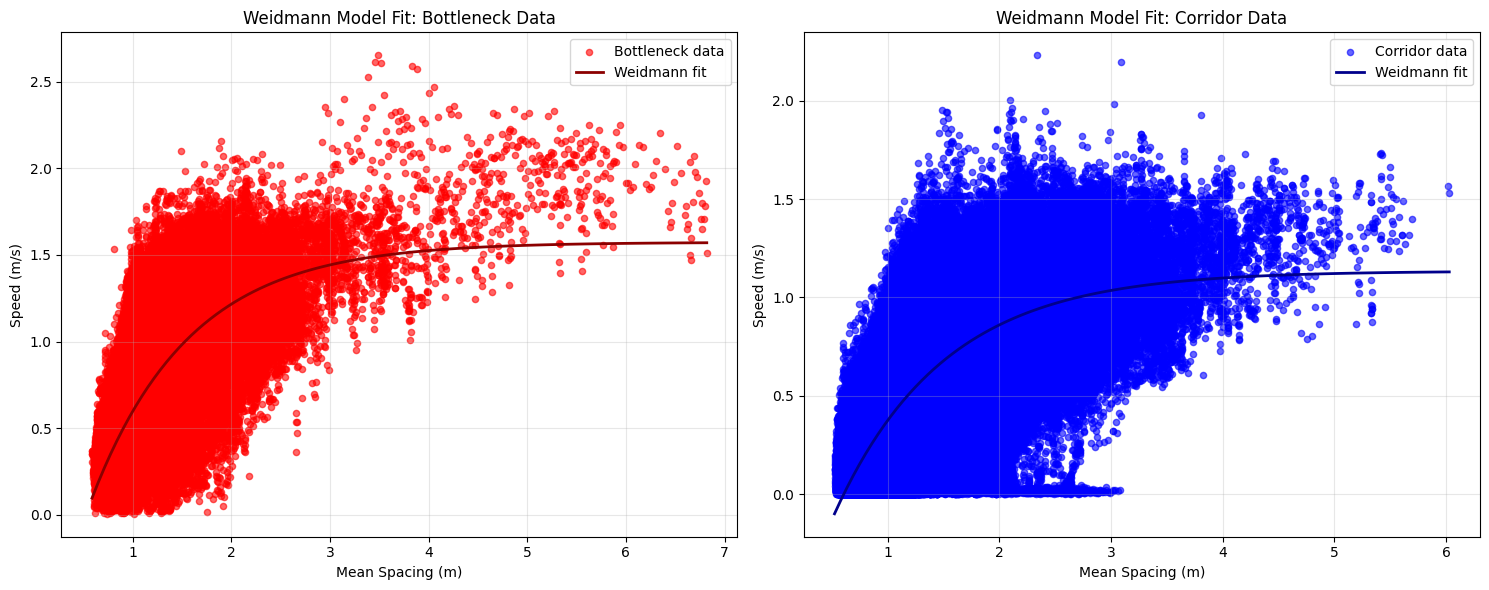


=== Parameter Comparison ===
v0 - Bottleneck: 1.573 m/s, Corridor: 1.134 m/s
T  - Bottleneck: 0.633 s, Corridor: 0.865 s
l  - Bottleneck: 0.523 m, Corridor: 0.606 m


In [7]:
from utils import weidmann
from scipy.optimize import curve_fit

# Fit Weidmann model to both datasets
print("=== Weidmann Model Calibration ===")

# Calibrate for Bottleneck data
popt_bottleneck, pcov_bottleneck = curve_fit(
    weidmann, spacing_bottleneck, speed_bottleneck
)
v0_bottleneck, T_bottleneck, l_bottleneck = popt_bottleneck

print("BOTTLENECK DATA - Fitted Parameters:")
print(f"  v0: {v0_bottleneck:.3f} m/s")
print(f"  T: {T_bottleneck:.3f} s")
print(f"  l: {l_bottleneck:.3f} m")

weidmann_params_bottleneck = (v0_bottleneck, T_bottleneck, l_bottleneck)

# Calibrate for Corridor data
popt_corridor, pcov_corridor = curve_fit(
    weidmann, spacing_corridor, speed_corridor
)
v0_corridor, T_corridor, l_corridor = popt_corridor

print("\nCORRIDOR DATA - Fitted Parameters:")
print(f"  v0: {v0_corridor:.3f} m/s")
print(f"  T: {T_corridor:.3f} s")
print(f"  l: {l_corridor:.3f} m")

weidmann_params_corridor = (v0_corridor, T_corridor, l_corridor)

# Create side-by-side Weidmann model fit visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bottleneck plot with fit
ax1 = axes[0]
ax1.scatter(
    spacing_bottleneck,
    speed_bottleneck,
    alpha=0.6,
    s=20,
    color="red",
    label="Bottleneck data",
)
spacing_smooth_bn = np.linspace(
    spacing_bottleneck.min(), spacing_bottleneck.max(), 100
)
speed_smooth_bn = weidmann(
    spacing_smooth_bn, v0_bottleneck, T_bottleneck, l_bottleneck
)
ax1.plot(
    spacing_smooth_bn,
    speed_smooth_bn,
    color="darkred",
    label="Weidmann fit",
    linewidth=2,
)
ax1.set_xlabel("Mean Spacing (m)")
ax1.set_ylabel("Speed (m/s)")
ax1.set_title("Weidmann Model Fit: Bottleneck Data")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Corridor plot with fit
ax2 = axes[1]
ax2.scatter(
    spacing_corridor,
    speed_corridor,
    alpha=0.6,
    s=20,
    color="blue",
    label="Corridor data",
)
spacing_smooth_cr = np.linspace(
    spacing_corridor.min(), spacing_corridor.max(), 100
)
speed_smooth_cr = weidmann(
    spacing_smooth_cr, v0_corridor, T_corridor, l_corridor
)
ax2.plot(
    spacing_smooth_cr,
    speed_smooth_cr,
    color="darkblue",
    label="Weidmann fit",
    linewidth=2,
)
ax2.set_xlabel("Mean Spacing (m)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_title("Weidmann Model Fit: Corridor Data")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare parameters between datasets
print(f"\n=== Parameter Comparison ===")
print(
    f"v0 - Bottleneck: {v0_bottleneck:.3f} m/s, Corridor: {v0_corridor:.3f} m/s"
)
print(f"T  - Bottleneck: {T_bottleneck:.3f} s, Corridor: {T_corridor:.3f} s")
print(f"l  - Bottleneck: {l_bottleneck:.3f} m, Corridor: {l_corridor:.3f} m")

### 5.1 Merge plots into one

c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


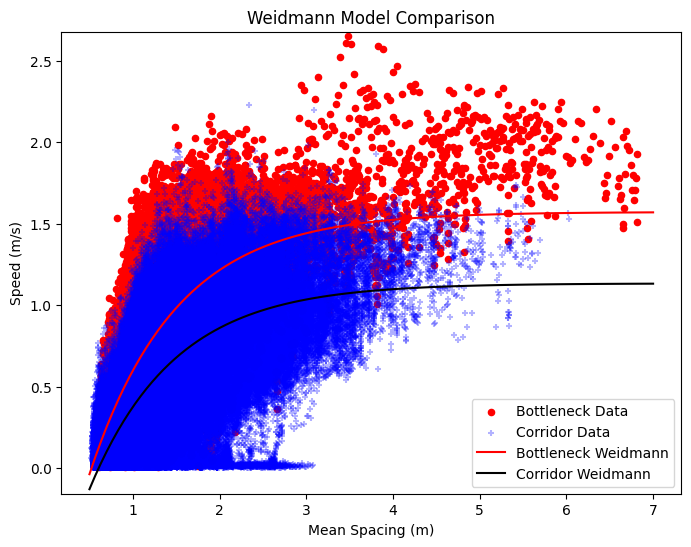

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plotting the Weidmann model for both datasets
spacing_smooth = np.linspace(0.5, 7, 100)  # Adjust range
ax.scatter(
    spacing_bottleneck,
    speed_bottleneck,
    color="red",
    alpha=1,
    label="Bottleneck Data",
    s=20,
)
ax.scatter(
    spacing_corridor,
    speed_corridor,
    color="blue",
    alpha=0.3,
    label="Corridor Data",
    marker="+",
    s=20,
)
ax.plot(
    spacing_smooth,
    weidmann(spacing_smooth, *weidmann_params_bottleneck),
    label="Bottleneck Weidmann",
    color="red",
)
ax.plot(
    spacing_smooth,
    weidmann(spacing_smooth, *weidmann_params_corridor),
    label="Corridor Weidmann",
    color="black",
)
ax.set_xlabel("Mean Spacing (m)")
ax.set_ylabel("Speed (m/s)")
ax.set_title("Weidmann Model Comparison")
ax.legend()
ax.margins(x=0.05, y=0.01)

## 6. Weidmann Model Cross-Dataset Evaluation

Systematic comparison of the Weidmann model performance across different training and testing combinations:
- Train on Corridor / Test on Corridor  
- Train on Bottleneck / Test on Bottleneck
- Train on Corridor / Test on Bottleneck
- Train on Bottleneck / Test on Corridor  
- Train on Combined (Corridor + Bottleneck) / Test on Corridor
- Train on Combined (Corridor + Bottleneck) / Test on Bottleneck
- Train on Combined (Corridor + Bottleneck) / Test on Combined

In [9]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import pandas as pd

# Extract spacing and speed data for each dataset
corridor_data = np.array(weidmann_corridor_df)
corridor_spacing = corridor_data[:, 0]  # mean spacing
corridor_speed = corridor_data[:, 1]  # observed speed

bottleneck_data = np.array(weidmann_bottleneck_df)
bottleneck_spacing = bottleneck_data[:, 0]  # mean spacing
bottleneck_speed = bottleneck_data[:, 1]  # observed speed

# Combined dataset
combined_spacing = np.concatenate([corridor_spacing, bottleneck_spacing])
combined_speed = np.concatenate([corridor_speed, bottleneck_speed])

print("=== Weidmann Model Cross-Dataset Evaluation ===")
print(f"Corridor dataset size: {len(corridor_spacing)}")
print(f"Bottleneck dataset size: {len(bottleneck_spacing)}")
print(f"Combined dataset size: {len(combined_spacing)}")

# Define all training/testing combinations
evaluation_scenarios = [
    (
        "Corridor",
        "Corridor",
        corridor_spacing,
        corridor_speed,
        corridor_spacing,
        corridor_speed,
    ),
    (
        "Bottleneck",
        "Bottleneck",
        bottleneck_spacing,
        bottleneck_speed,
        bottleneck_spacing,
        bottleneck_speed,
    ),
    (
        "Corridor",
        "Bottleneck",
        corridor_spacing,
        corridor_speed,
        bottleneck_spacing,
        bottleneck_speed,
    ),
    (
        "Bottleneck",
        "Corridor",
        bottleneck_spacing,
        bottleneck_speed,
        corridor_spacing,
        corridor_speed,
    ),
    (
        "Combined",
        "Corridor",
        combined_spacing,
        combined_speed,
        corridor_spacing,
        corridor_speed,
    ),
    (
        "Combined",
        "Bottleneck",
        combined_spacing,
        combined_speed,
        bottleneck_spacing,
        bottleneck_speed,
    ),
    (
        "Combined",
        "Combined",
        combined_spacing,
        combined_speed,
        combined_spacing,
        combined_speed,
    ),
]

# Store results
weidmann_results = []

print("\n" + "=" * 80)
print("WEIDMANN MODEL EVALUATION RESULTS")
print("=" * 80)

for (
    train_name,
    test_name,
    train_spacing,
    train_speed,
    test_spacing,
    test_speed,
) in evaluation_scenarios:
    print(f"\nTrain: {train_name} | Test: {test_name}")
    print("-" * 50)

    try:
        # Fit Weidmann model parameters on training data
        popt, pcov = curve_fit(weidmann, train_spacing, train_speed)
        v0_fitted, T_fitted, l_fitted = popt

        # Make predictions on test data
        predicted_speed = weidmann(test_spacing, v0_fitted, T_fitted, l_fitted)

        # Calculate MSE
        mse = mean_squared_error(test_speed, predicted_speed)

        # Store results
        result = {
            "Train Dataset": train_name,
            "Test Dataset": test_name,
            "MSE": mse,
            "v0": v0_fitted,
            "T": T_fitted,
            "l": l_fitted,
            "Train Size": len(train_spacing),
            "Test Size": len(test_spacing),
        }
        weidmann_results.append(result)

        print(f"Fitted Parameters:")
        print(f"  v0 (desired speed): {v0_fitted:.4f} m/s")
        print(f"  T (time gap): {T_fitted:.4f} s")
        print(f"  l (pedestrian size): {l_fitted:.4f} m")
        print(f"Test MSE: {mse:.6f}")

    except Exception as e:
        print(f"Error fitting model: {e}")

print("\n" + "=" * 80)
print("SUMMARY TABLE")
print("=" * 80)

# Create summary DataFrame
results_df = pd.DataFrame(weidmann_results)
print(
    results_df[
        ["Train Dataset", "Test Dataset", "MSE", "Train Size", "Test Size"]
    ].to_string(index=False)
)

print(
    f"\nBest performing combination: {results_df.loc[results_df['MSE'].idxmin(), 'Train Dataset']} → {results_df.loc[results_df['MSE'].idxmin(), 'Test Dataset']} (MSE: {results_df['MSE'].min():.6f})"
)
print(
    f"Worst performing combination: {results_df.loc[results_df['MSE'].idxmax(), 'Train Dataset']} → {results_df.loc[results_df['MSE'].idxmax(), 'Test Dataset']} (MSE: {results_df['MSE'].max():.6f})"
)

# Store results for later use
weidmann_comparison_results = results_df

=== Weidmann Model Cross-Dataset Evaluation ===
Corridor dataset size: 558836
Bottleneck dataset size: 250641
Combined dataset size: 809477

WEIDMANN MODEL EVALUATION RESULTS

Train: Corridor | Test: Corridor
--------------------------------------------------
Fitted Parameters:
  v0 (desired speed): 1.1342 m/s
  T (time gap): 0.8649 s
  l (pedestrian size): 0.6057 m
Test MSE: 0.053497

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Fitted Parameters:
  v0 (desired speed): 1.5727 m/s
  T (time gap): 0.6329 s
  l (pedestrian size): 0.5232 m
Test MSE: 0.051440

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Fitted Parameters:
  v0 (desired speed): 1.1342 m/s
  T (time gap): 0.8649 s
  l (pedestrian size): 0.6057 m
Test MSE: 0.108460

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Fitted Parameters:
  v0 (desired speed): 1.5727 m/s
  T (time gap): 0.6329 s
  l (pedestrian 

### 6.1 Visualization of the results

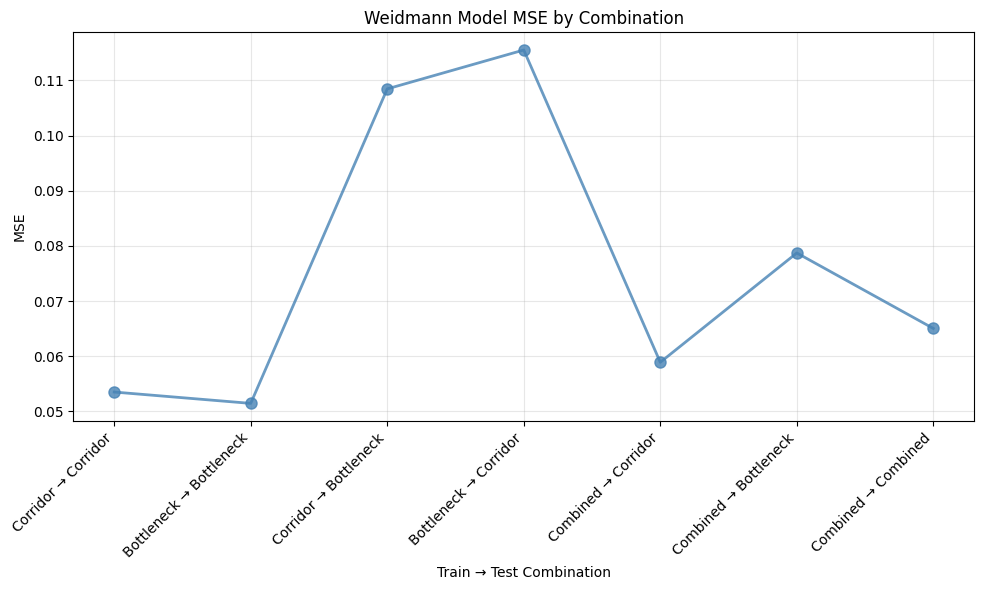


PERFORMANCE ANALYSIS
Same-domain average MSE: 0.056655
Cross-domain average MSE: 0.090393

Generalization gap: 0.033738

Combined training average MSE: 0.067543


In [10]:
# Visualization of results
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot of MSE results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prepare data for scatter plot
mse_values = weidmann_comparison_results["MSE"].values
labels = [
    f"{row['Train Dataset']} → {row['Test Dataset']}"
    for _, row in weidmann_comparison_results.iterrows()
]

# Create scatter plot with connecting line
ax.plot(
    range(len(mse_values)),
    mse_values,
    "o-",
    color="steelblue",
    markersize=8,
    linewidth=2,
    alpha=0.8,
)

ax.set_xlabel("Train → Test Combination")
ax.set_ylabel("MSE")
ax.set_title("Weidmann Model MSE by Combination")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance analysis
print("\n" + "=" * 60)
print("PERFORMANCE ANALYSIS")
print("=" * 60)

same_domain_results = weidmann_comparison_results[
    weidmann_comparison_results["Train Dataset"]
    == weidmann_comparison_results["Test Dataset"]
]
cross_domain_results = weidmann_comparison_results[
    weidmann_comparison_results["Train Dataset"]
    != weidmann_comparison_results["Test Dataset"]
]

print(f"Same-domain average MSE: {same_domain_results['MSE'].mean():.6f}")
print(f"Cross-domain average MSE: {cross_domain_results['MSE'].mean():.6f}")

print(
    f"\nGeneralization gap: {cross_domain_results['MSE'].mean() - same_domain_results['MSE'].mean():.6f}"
)

# Combined model performance
combined_train_results = weidmann_comparison_results[
    weidmann_comparison_results["Train Dataset"] == "Combined"
]
print(
    f"\nCombined training average MSE: {combined_train_results['MSE'].mean():.6f}"
)

## 7. Neural Network Model Cross-Dataset Evaluation

Neural network evaluation with consistent dataset sizes:
- **Data consistency**: All datasets (Corridor, Bottleneck, Combined) use sampled data
- **Purpose**: Quick validation with fair comparison across all scenarios
- **Same framework**: All 7 training/testing combinations as Weidmann model

## 7.1. Test with various layers and neurons

--- Running all experiments... ---
Evaluating model with layers: [1]...
=== Neural Network Model Cross-Dataset Evaluation
Original dataset sizes: Corridor=558836, Bottleneck=250641
Sampled dataset sizes: Corridor=10000, Bottleneck=10000
Combined sampled size: 10000
Speed optimization: Using max 10000 samples per dataset

NEURAL NETWORK MODEL EVALUATION RESULTS (TESTING - SMALL SUBSET)

Train: Corridor | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


  Mean Train MSE: 0.095292
  Std Train MSE: 0.015959
  Mean Test MSE: 0.100851
  Std Test MSE: 0.017342

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


  Mean Train MSE: 0.099215
  Std Train MSE: 0.019853
  Mean Test MSE: 0.101076
  Std Test MSE: 0.021227

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


  Mean Train MSE: 0.102421
  Std Train MSE: 0.018203
  Mean Test MSE: 0.154255
  Std Test MSE: 0.018658

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


  Mean Train MSE: 0.096943
  Std Train MSE: 0.018934
  Mean Test MSE: 0.146445
  Std Test MSE: 0.015087

Train: Combined | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


  Mean Train MSE: 0.116439
  Std Train MSE: 0.011865
  Mean Test MSE: 0.116737
  Std Test MSE: 0.006780

Train: Combined | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


  Mean Train MSE: 0.118819
  Std Train MSE: 0.010055
  Mean Test MSE: 0.120383
  Std Test MSE: 0.012381

Train: Combined | Test: Combined
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


  Mean Train MSE: 0.114153
  Std Train MSE: 0.012645
  Mean Test MSE: 0.116277
  Std Test MSE: 0.011471

NEURAL NETWORK SUMMARY TABLE
Train Dataset Test Dataset  Mean MSE Train  Std MSE Train  Mean MSE Test  Std MSE Test  Train Size  Test Size
     Corridor     Corridor        0.095292       0.015959       0.100851      0.017342        5000       5000
   Bottleneck   Bottleneck        0.099215       0.019853       0.101076      0.021227        5000       5000
     Corridor   Bottleneck        0.102421       0.018203       0.154255      0.018658        5000       5000
   Bottleneck     Corridor        0.096943       0.018934       0.146445      0.015087        5000       5000
     Combined     Corridor        0.116439       0.011865       0.116737      0.006780        5000       5000
     Combined   Bottleneck        0.118819       0.010055       0.120383      0.012381        5000       5000
     Combined     Combined        0.114153       0.012645       0.116277      0.011471        50

Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


  Mean Train MSE: 0.077191
  Std Train MSE: 0.013716
  Mean Test MSE: 0.082917
  Std Test MSE: 0.015059

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


  Mean Train MSE: 0.083943
  Std Train MSE: 0.018863
  Mean Test MSE: 0.086404
  Std Test MSE: 0.018368

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


  Mean Train MSE: 0.082834
  Std Train MSE: 0.013698
  Mean Test MSE: 0.148498
  Std Test MSE: 0.012052

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


  Mean Train MSE: 0.079030
  Std Train MSE: 0.013071
  Mean Test MSE: 0.141074
  Std Test MSE: 0.011494

Train: Combined | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


  Mean Train MSE: 0.103197
  Std Train MSE: 0.014210
  Mean Test MSE: 0.097544
  Std Test MSE: 0.008636

Train: Combined | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


  Mean Train MSE: 0.093023
  Std Train MSE: 0.007624
  Mean Test MSE: 0.101457
  Std Test MSE: 0.011896

Train: Combined | Test: Combined
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


  Mean Train MSE: 0.101168
  Std Train MSE: 0.013710
  Mean Test MSE: 0.102905
  Std Test MSE: 0.013271

NEURAL NETWORK SUMMARY TABLE
Train Dataset Test Dataset  Mean MSE Train  Std MSE Train  Mean MSE Test  Std MSE Test  Train Size  Test Size
     Corridor     Corridor        0.077191       0.013716       0.082917      0.015059        5000       5000
   Bottleneck   Bottleneck        0.083943       0.018863       0.086404      0.018368        5000       5000
     Corridor   Bottleneck        0.082834       0.013698       0.148498      0.012052        5000       5000
   Bottleneck     Corridor        0.079030       0.013071       0.141074      0.011494        5000       5000
     Combined     Corridor        0.103197       0.014210       0.097544      0.008636        5000       5000
     Combined   Bottleneck        0.093023       0.007624       0.101457      0.011896        5000       5000
     Combined     Combined        0.101168       0.013710       0.102905      0.013271        50

Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


  Mean Train MSE: 0.082105
  Std Train MSE: 0.021255
  Mean Test MSE: 0.088633
  Std Test MSE: 0.021204

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.20s/it]


  Mean Train MSE: 0.082346
  Std Train MSE: 0.017764
  Mean Test MSE: 0.085045
  Std Test MSE: 0.017324

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


  Mean Train MSE: 0.077286
  Std Train MSE: 0.019674
  Mean Test MSE: 0.145210
  Std Test MSE: 0.014923

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.18s/it]


  Mean Train MSE: 0.077921
  Std Train MSE: 0.016044
  Mean Test MSE: 0.141013
  Std Test MSE: 0.018493

Train: Combined | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


  Mean Train MSE: 0.094064
  Std Train MSE: 0.014807
  Mean Test MSE: 0.095941
  Std Test MSE: 0.016061

Train: Combined | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


  Mean Train MSE: 0.109867
  Std Train MSE: 0.021414
  Mean Test MSE: 0.116547
  Std Test MSE: 0.022563

Train: Combined | Test: Combined
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


  Mean Train MSE: 0.095617
  Std Train MSE: 0.018523
  Mean Test MSE: 0.098072
  Std Test MSE: 0.016711

NEURAL NETWORK SUMMARY TABLE
Train Dataset Test Dataset  Mean MSE Train  Std MSE Train  Mean MSE Test  Std MSE Test  Train Size  Test Size
     Corridor     Corridor        0.082105       0.021255       0.088633      0.021204        5000       5000
   Bottleneck   Bottleneck        0.082346       0.017764       0.085045      0.017324        5000       5000
     Corridor   Bottleneck        0.077286       0.019674       0.145210      0.014923        5000       5000
   Bottleneck     Corridor        0.077921       0.016044       0.141013      0.018493        5000       5000
     Combined     Corridor        0.094064       0.014807       0.095941      0.016061        5000       5000
     Combined   Bottleneck        0.109867       0.021414       0.116547      0.022563        5000       5000
     Combined     Combined        0.095617       0.018523       0.098072      0.016711        50

Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


  Mean Train MSE: 0.079421
  Std Train MSE: 0.024836
  Mean Test MSE: 0.085659
  Std Test MSE: 0.025638

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


  Mean Train MSE: 0.068944
  Std Train MSE: 0.020046
  Mean Test MSE: 0.071988
  Std Test MSE: 0.022219

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


  Mean Train MSE: 0.084280
  Std Train MSE: 0.024699
  Mean Test MSE: 0.136631
  Std Test MSE: 0.017733

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


  Mean Train MSE: 0.088094
  Std Train MSE: 0.024964
  Mean Test MSE: 0.138721
  Std Test MSE: 0.007285

Train: Combined | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


  Mean Train MSE: 0.092278
  Std Train MSE: 0.025344
  Mean Test MSE: 0.090230
  Std Test MSE: 0.019154

Train: Combined | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


  Mean Train MSE: 0.090130
  Std Train MSE: 0.021115
  Mean Test MSE: 0.096628
  Std Test MSE: 0.019715

Train: Combined | Test: Combined
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


  Mean Train MSE: 0.101669
  Std Train MSE: 0.020150
  Mean Test MSE: 0.104811
  Std Test MSE: 0.019761

NEURAL NETWORK SUMMARY TABLE
Train Dataset Test Dataset  Mean MSE Train  Std MSE Train  Mean MSE Test  Std MSE Test  Train Size  Test Size
     Corridor     Corridor        0.079421       0.024836       0.085659      0.025638        5000       5000
   Bottleneck   Bottleneck        0.068944       0.020046       0.071988      0.022219        5000       5000
     Corridor   Bottleneck        0.084280       0.024699       0.136631      0.017733        5000       5000
   Bottleneck     Corridor        0.088094       0.024964       0.138721      0.007285        5000       5000
     Combined     Corridor        0.092278       0.025344       0.090230      0.019154        5000       5000
     Combined   Bottleneck        0.090130       0.021115       0.096628      0.019715        5000       5000
     Combined     Combined        0.101669       0.020150       0.104811      0.019761        50

Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


  Mean Train MSE: 0.070211
  Std Train MSE: 0.016866
  Mean Test MSE: 0.077955
  Std Test MSE: 0.018117

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


  Mean Train MSE: 0.100299
  Std Train MSE: 0.031847
  Mean Test MSE: 0.103987
  Std Test MSE: 0.032071

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


  Mean Train MSE: 0.070727
  Std Train MSE: 0.015802
  Mean Test MSE: 0.135125
  Std Test MSE: 0.010327

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


  Mean Train MSE: 0.071695
  Std Train MSE: 0.005794
  Mean Test MSE: 0.136657
  Std Test MSE: 0.010361

Train: Combined | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


  Mean Train MSE: 0.095125
  Std Train MSE: 0.022797
  Mean Test MSE: 0.094580
  Std Test MSE: 0.015101

Train: Combined | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


  Mean Train MSE: 0.085114
  Std Train MSE: 0.006892
  Mean Test MSE: 0.091790
  Std Test MSE: 0.007897

Train: Combined | Test: Combined
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


  Mean Train MSE: 0.085158
  Std Train MSE: 0.006241
  Mean Test MSE: 0.090763
  Std Test MSE: 0.007727

NEURAL NETWORK SUMMARY TABLE
Train Dataset Test Dataset  Mean MSE Train  Std MSE Train  Mean MSE Test  Std MSE Test  Train Size  Test Size
     Corridor     Corridor        0.070211       0.016866       0.077955      0.018117        5000       5000
   Bottleneck   Bottleneck        0.100299       0.031847       0.103987      0.032071        5000       5000
     Corridor   Bottleneck        0.070727       0.015802       0.135125      0.010327        5000       5000
   Bottleneck     Corridor        0.071695       0.005794       0.136657      0.010361        5000       5000
     Combined     Corridor        0.095125       0.022797       0.094580      0.015101        5000       5000
     Combined   Bottleneck        0.085114       0.006892       0.091790      0.007897        5000       5000
     Combined     Combined        0.085158       0.006241       0.090763      0.007727        50

Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


  Mean Train MSE: 0.070714
  Std Train MSE: 0.024695
  Mean Test MSE: 0.076710
  Std Test MSE: 0.023541

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


  Mean Train MSE: 0.079358
  Std Train MSE: 0.024214
  Mean Test MSE: 0.082278
  Std Test MSE: 0.024425

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:35<00:00,  3.51s/it]


  Mean Train MSE: 0.063764
  Std Train MSE: 0.010276
  Mean Test MSE: 0.130861
  Std Test MSE: 0.006617

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


  Mean Train MSE: 0.063792
  Std Train MSE: 0.008674
  Mean Test MSE: 0.128683
  Std Test MSE: 0.012011

Train: Combined | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


  Mean Train MSE: 0.079914
  Std Train MSE: 0.010689
  Mean Test MSE: 0.082270
  Std Test MSE: 0.011157

Train: Combined | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


  Mean Train MSE: 0.082195
  Std Train MSE: 0.018764
  Mean Test MSE: 0.090450
  Std Test MSE: 0.018004

Train: Combined | Test: Combined
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


  Mean Train MSE: 0.087628
  Std Train MSE: 0.020512
  Mean Test MSE: 0.091423
  Std Test MSE: 0.017034

NEURAL NETWORK SUMMARY TABLE
Train Dataset Test Dataset  Mean MSE Train  Std MSE Train  Mean MSE Test  Std MSE Test  Train Size  Test Size
     Corridor     Corridor        0.070714       0.024695       0.076710      0.023541        5000       5000
   Bottleneck   Bottleneck        0.079358       0.024214       0.082278      0.024425        5000       5000
     Corridor   Bottleneck        0.063764       0.010276       0.130861      0.006617        5000       5000
   Bottleneck     Corridor        0.063792       0.008674       0.128683      0.012011        5000       5000
     Combined     Corridor        0.079914       0.010689       0.082270      0.011157        5000       5000
     Combined   Bottleneck        0.082195       0.018764       0.090450      0.018004        5000       5000
     Combined     Combined        0.087628       0.020512       0.091423      0.017034        50

Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


  Mean Train MSE: 0.055297
  Std Train MSE: 0.008929
  Mean Test MSE: 0.063112
  Std Test MSE: 0.007655

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


  Mean Train MSE: 0.058444
  Std Train MSE: 0.003973
  Mean Test MSE: 0.063589
  Std Test MSE: 0.003503

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


  Mean Train MSE: 0.060736
  Std Train MSE: 0.015212
  Mean Test MSE: 0.135336
  Std Test MSE: 0.009978

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.10s/it]


  Mean Train MSE: 0.058338
  Std Train MSE: 0.008656
  Mean Test MSE: 0.127460
  Std Test MSE: 0.008238

Train: Combined | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


  Mean Train MSE: 0.073197
  Std Train MSE: 0.006238
  Mean Test MSE: 0.075318
  Std Test MSE: 0.006310

Train: Combined | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


  Mean Train MSE: 0.072430
  Std Train MSE: 0.006588
  Mean Test MSE: 0.082712
  Std Test MSE: 0.007034

Train: Combined | Test: Combined
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


  Mean Train MSE: 0.070195
  Std Train MSE: 0.006332
  Mean Test MSE: 0.076157
  Std Test MSE: 0.006420

NEURAL NETWORK SUMMARY TABLE
Train Dataset Test Dataset  Mean MSE Train  Std MSE Train  Mean MSE Test  Std MSE Test  Train Size  Test Size
     Corridor     Corridor        0.055297       0.008929       0.063112      0.007655        5000       5000
   Bottleneck   Bottleneck        0.058444       0.003973       0.063589      0.003503        5000       5000
     Corridor   Bottleneck        0.060736       0.015212       0.135336      0.009978        5000       5000
   Bottleneck     Corridor        0.058338       0.008656       0.127460      0.008238        5000       5000
     Combined     Corridor        0.073197       0.006238       0.075318      0.006310        5000       5000
     Combined   Bottleneck        0.072430       0.006588       0.082712      0.007034        5000       5000
     Combined     Combined        0.070195       0.006332       0.076157      0.006420        50

Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


  Mean Train MSE: 0.084547
  Std Train MSE: 0.032686
  Mean Test MSE: 0.091331
  Std Test MSE: 0.031111

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


  Mean Train MSE: 0.072166
  Std Train MSE: 0.021931
  Mean Test MSE: 0.076274
  Std Test MSE: 0.021181

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


  Mean Train MSE: 0.053020
  Std Train MSE: 0.011719
  Mean Test MSE: 0.125057
  Std Test MSE: 0.010602

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:30<00:00,  3.10s/it]


  Mean Train MSE: 0.070309
  Std Train MSE: 0.024035
  Mean Test MSE: 0.133176
  Std Test MSE: 0.006423

Train: Combined | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


  Mean Train MSE: 0.102392
  Std Train MSE: 0.025065
  Mean Test MSE: 0.102042
  Std Test MSE: 0.023172

Train: Combined | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


  Mean Train MSE: 0.078743
  Std Train MSE: 0.017497
  Mean Test MSE: 0.086377
  Std Test MSE: 0.015159

Train: Combined | Test: Combined
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


  Mean Train MSE: 0.100556
  Std Train MSE: 0.028925
  Mean Test MSE: 0.103656
  Std Test MSE: 0.025978

NEURAL NETWORK SUMMARY TABLE
Train Dataset Test Dataset  Mean MSE Train  Std MSE Train  Mean MSE Test  Std MSE Test  Train Size  Test Size
     Corridor     Corridor        0.084547       0.032686       0.091331      0.031111        5000       5000
   Bottleneck   Bottleneck        0.072166       0.021931       0.076274      0.021181        5000       5000
     Corridor   Bottleneck        0.053020       0.011719       0.125057      0.010602        5000       5000
   Bottleneck     Corridor        0.070309       0.024035       0.133176      0.006423        5000       5000
     Combined     Corridor        0.102392       0.025065       0.102042      0.023172        5000       5000
     Combined   Bottleneck        0.078743       0.017497       0.086377      0.015159        5000       5000
     Combined     Combined        0.100556       0.028925       0.103656      0.025978        50

Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:32<00:00,  3.24s/it]


  Mean Train MSE: 0.048733
  Std Train MSE: 0.033855
  Mean Test MSE: 0.060497
  Std Test MSE: 0.030552

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


  Mean Train MSE: 0.032418
  Std Train MSE: 0.002252
  Mean Test MSE: 0.043270
  Std Test MSE: 0.001386

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.20s/it]


  Mean Train MSE: 0.041999
  Std Train MSE: 0.026472
  Mean Test MSE: 0.123082
  Std Test MSE: 0.015099

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]


  Mean Train MSE: 0.031498
  Std Train MSE: 0.001845
  Mean Test MSE: 0.139898
  Std Test MSE: 0.014437

Train: Combined | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


  Mean Train MSE: 0.054493
  Std Train MSE: 0.025119
  Mean Test MSE: 0.065136
  Std Test MSE: 0.021094

Train: Combined | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


  Mean Train MSE: 0.055575
  Std Train MSE: 0.025260
  Mean Test MSE: 0.072425
  Std Test MSE: 0.020963

Train: Combined | Test: Combined
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


  Mean Train MSE: 0.045900
  Std Train MSE: 0.001848
  Mean Test MSE: 0.062228
  Std Test MSE: 0.001720

NEURAL NETWORK SUMMARY TABLE
Train Dataset Test Dataset  Mean MSE Train  Std MSE Train  Mean MSE Test  Std MSE Test  Train Size  Test Size
     Corridor     Corridor        0.048733       0.033855       0.060497      0.030552        5000       5000
   Bottleneck   Bottleneck        0.032418       0.002252       0.043270      0.001386        5000       5000
     Corridor   Bottleneck        0.041999       0.026472       0.123082      0.015099        5000       5000
   Bottleneck     Corridor        0.031498       0.001845       0.139898      0.014437        5000       5000
     Combined     Corridor        0.054493       0.025119       0.065136      0.021094        5000       5000
     Combined   Bottleneck        0.055575       0.025260       0.072425      0.020963        5000       5000
     Combined     Combined        0.045900       0.001848       0.062228      0.001720        50

Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


  Mean Train MSE: 0.031268
  Std Train MSE: 0.002238
  Mean Test MSE: 0.046525
  Std Test MSE: 0.001457

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


  Mean Train MSE: 0.031055
  Std Train MSE: 0.002625
  Mean Test MSE: 0.044059
  Std Test MSE: 0.001327

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.30s/it]


  Mean Train MSE: 0.032372
  Std Train MSE: 0.001784
  Mean Test MSE: 0.118120
  Std Test MSE: 0.008295

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


  Mean Train MSE: 0.031827
  Std Train MSE: 0.001125
  Mean Test MSE: 0.141069
  Std Test MSE: 0.008373

Train: Combined | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


  Mean Train MSE: 0.046484
  Std Train MSE: 0.002902
  Mean Test MSE: 0.060827
  Std Test MSE: 0.005658

Train: Combined | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:29<00:00,  3.00s/it]


  Mean Train MSE: 0.047050
  Std Train MSE: 0.004263
  Mean Test MSE: 0.064611
  Std Test MSE: 0.006333

Train: Combined | Test: Combined
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


  Mean Train MSE: 0.046032
  Std Train MSE: 0.001837
  Mean Test MSE: 0.063497
  Std Test MSE: 0.002383

NEURAL NETWORK SUMMARY TABLE
Train Dataset Test Dataset  Mean MSE Train  Std MSE Train  Mean MSE Test  Std MSE Test  Train Size  Test Size
     Corridor     Corridor        0.031268       0.002238       0.046525      0.001457        5000       5000
   Bottleneck   Bottleneck        0.031055       0.002625       0.044059      0.001327        5000       5000
     Corridor   Bottleneck        0.032372       0.001784       0.118120      0.008295        5000       5000
   Bottleneck     Corridor        0.031827       0.001125       0.141069      0.008373        5000       5000
     Combined     Corridor        0.046484       0.002902       0.060827      0.005658        5000       5000
     Combined   Bottleneck        0.047050       0.004263       0.064611      0.006333        5000       5000
     Combined     Combined        0.046032       0.001837       0.063497      0.002383        50

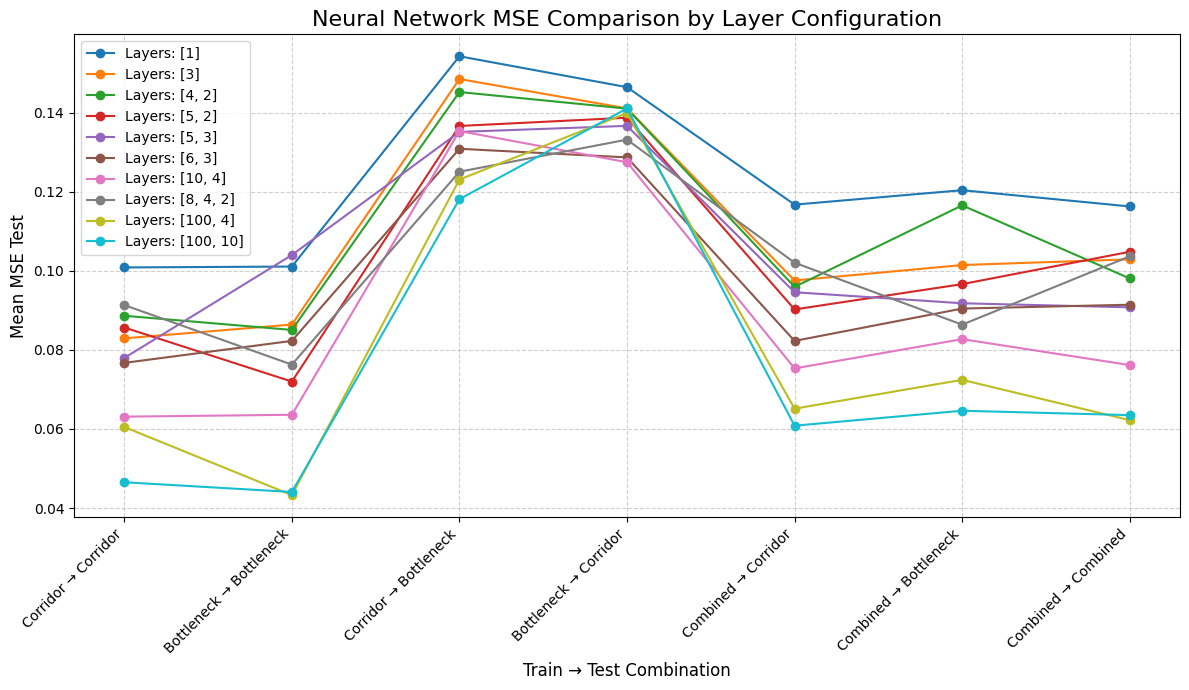

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import time

# Put all models in a list
layer_configs = [
    [1],
    [3],
    [4, 2],
    [5, 2],
    [5, 3],
    [6, 3],
    [10, 4],
    [8, 4, 2],
    [100, 4],
    [100, 10],
]

# Running the experiment and collect result
print("--- Running all experiments... ---")
all_results = []  # Store the result
training_times = []  # Store training times

for layer in layer_configs:
    print(f"Evaluating model with layers: {layer}...")
    start_time = time.time()
    single_run_df = evaluate_nn(
        dataset_corridor_nn,
        dataset_bottleneck_nn,
        sample_size=10000,
        layers=layer,
        epochs=5,
        batch_size=256,
        learning_rate=0.01,
        activation="relu",
        n_bootstrap=10,
        verbose=0,
    )
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    single_run_df["Model"] = str(layer)
    all_results.append(single_run_df)

# Combine all results into a dataFrame
results_df = pd.concat(all_results, ignore_index=True)
print("\n--- All experiments finished. ---")

print("\n--- Final Results Table ---")
print(
    results_df[
        ["Model", "Train Dataset", "Test Dataset", "Mean MSE Test"]
    ].to_string()
)

# Plot the result
plt.figure(figsize=(12, 7))
plt.title("Neural Network MSE Comparison by Layer Configuration", fontsize=16)

for model_config in results_df["Model"].unique():
    model_subset = results_df[results_df["Model"] == model_config]
    plt.plot(
        model_subset["Mean MSE Test"].values,
        label=f"Layers: {model_config}",
        marker="o",
    )

plt.xlabel("Train → Test Combination", fontsize=12)
plt.ylabel("Mean MSE Test", fontsize=12)
x_labels = (
    results_df["Train Dataset"].iloc[:7]
    + " → "
    + results_df["Test Dataset"].iloc[:7]
).tolist()
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha="right")

plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Comparison of results

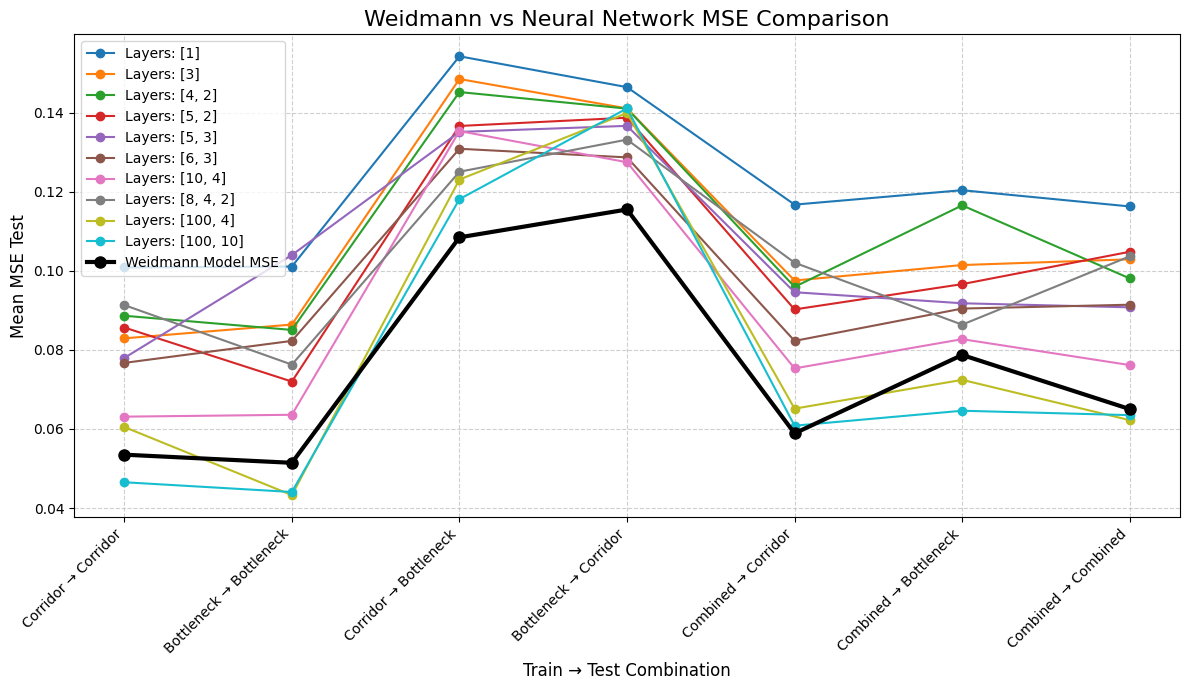

In [23]:
# Plot the result
plt.figure(figsize=(12, 7))
plt.title("Weidmann vs Neural Network MSE Comparison", fontsize=16)

for model_config in results_df["Model"].unique():
    model_subset = results_df[results_df["Model"] == model_config]
    plt.plot(
        model_subset["Mean MSE Test"].values,
        label=f"Layers: {model_config}",
        marker="o",
    )

plt.xlabel("Train → Test Combination", fontsize=12)
plt.ylabel("Mean MSE Test", fontsize=12)
x_labels = (
    results_df["Train Dataset"].iloc[:7]
    + " → "
    + results_df["Test Dataset"].iloc[:7]
).tolist()
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha="right")

plt.plot(
    range(len(mse_values)),
    mse_values,
    "o-",
    color="black",
    markersize=8,
    linewidth=3,
    alpha=1,
    label="Weidmann Model MSE",
)


plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Model Performance Summary:
    Model  Complexity  Avg_Test_MSE  Avg_Train_MSE  Training_Time
      [1]           1      0.122289       0.106183     141.340523
      [3]           3      0.108686       0.088627     132.608984
   [4, 2]           6      0.110066       0.088458     160.838272
   [5, 2]           7      0.103524       0.086402     166.691948
   [5, 3]           8      0.104408       0.082618     170.206746
   [6, 3]           9      0.097525       0.075338     169.066635
  [10, 4]          14      0.089098       0.064091     148.553112
[8, 4, 2]          14      0.102559       0.080248     189.965024
 [100, 4]         104      0.080934       0.044374     172.243463
[100, 10]         110      0.076958       0.038012     181.384728


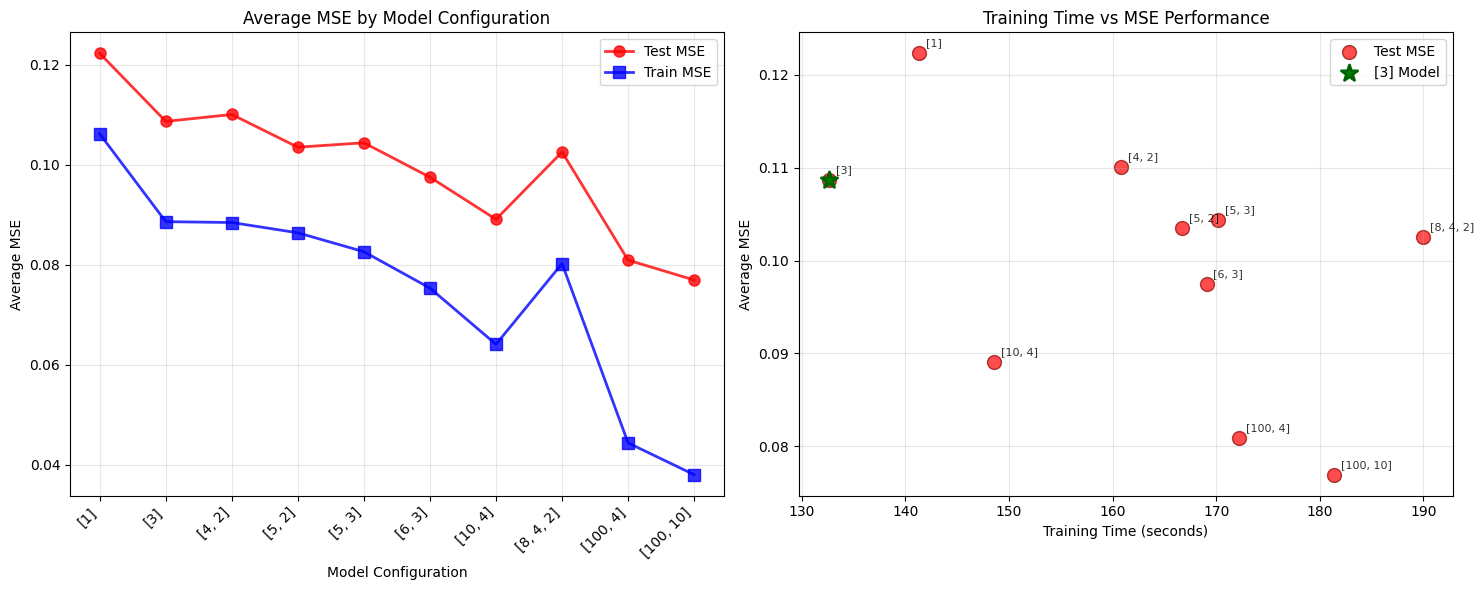


Performance Analysis:
Best Test MSE: [100, 10] with MSE = 0.076958
Best Train MSE: [100, 10] with MSE = 0.038012
Least overfitting: [1] with gap = 0.016106
Most overfitting: [100, 10] with gap = 0.038946

Timing Analysis:
Fastest training: [3] with 132.61 seconds
Slowest training: [8, 4, 2] with 189.97 seconds
Most efficient model: [10, 4] (best performance/time ratio)

[3] Model Analysis:
  Training Time: 132.61 seconds
  Test MSE: 0.108686
  Efficiency Rank: 4 out of 10
  Speed Rank: 1 out of 10 (1=fastest)
  Performance Rank: 8 out of 10 (1=best)


In [24]:
# Layer vs MSE Performance Analysis
import matplotlib.pyplot as plt
import numpy as np

# Calculate average MSE across all train/test combinations for each model
model_performance = []

for model_config in results_df["Model"].unique():
    model_subset = results_df[results_df["Model"] == model_config]
    
    avg_test_mse = model_subset["Mean MSE Test"].mean()
    avg_train_mse = model_subset["Mean MSE Train"].mean()
    
    # Calculate model complexity (total number of parameters)
    layer_config = eval(model_config)  # Convert string back to list
    
    # Simple complexity metric: sum of neurons in all layers
    complexity = sum(layer_config)
    
    model_performance.append({
        'Model': model_config,
        'Layers': layer_config,
        'Complexity': complexity,
        'Avg_Test_MSE': avg_test_mse,
        'Avg_Train_MSE': avg_train_mse
    })

# Convert to DataFrame for easier handling
perf_df = pd.DataFrame(model_performance)
perf_df = perf_df.sort_values('Complexity')

# Add training times to the performance dataframe
perf_df['Training_Time'] = training_times

print("Model Performance Summary:")
print(perf_df[['Model', 'Complexity', 'Avg_Test_MSE', 'Avg_Train_MSE', 'Training_Time']].to_string(index=False))

# Create side-by-side visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Model Configuration vs MSE - Scatter plot with lines
x_pos = range(len(perf_df))

ax1.plot(x_pos, perf_df['Avg_Test_MSE'], 
         'o-', color='red', label='Test MSE', linewidth=2, markersize=8, alpha=0.8)
ax1.plot(x_pos, perf_df['Avg_Train_MSE'], 
         's-', color='blue', label='Train MSE', linewidth=2, markersize=8, alpha=0.8)

ax1.set_xlabel('Model Configuration')
ax1.set_ylabel('Average MSE')
ax1.set_title('Average MSE by Model Configuration')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(perf_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Training Time vs MSE - Scatter plot
ax2.scatter(perf_df['Training_Time'], perf_df['Avg_Test_MSE'], 
           color='red', s=100, alpha=0.7, label='Test MSE', edgecolor='darkred')
# Add model labels to points
for i, row in perf_df.iterrows():
    ax2.annotate(row['Model'], 
                (row['Training_Time'], row['Avg_Test_MSE']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

# Highlight [3] model
model_3_row = perf_df[perf_df['Model'] == '[3]']
if not model_3_row.empty:
    ax2.scatter(model_3_row['Training_Time'], model_3_row['Avg_Test_MSE'], 
               color='green', s=150, marker='*', label='[3] Model', 
               edgecolor='darkgreen', linewidth=2)

ax2.set_xlabel('Training Time (seconds)')
ax2.set_ylabel('Average MSE')
ax2.set_title('Training Time vs MSE Performance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis
print(f"\nPerformance Analysis:")
print(f"Best Test MSE: {perf_df.loc[perf_df['Avg_Test_MSE'].idxmin(), 'Model']} with MSE = {perf_df['Avg_Test_MSE'].min():.6f}")
print(f"Best Train MSE: {perf_df.loc[perf_df['Avg_Train_MSE'].idxmin(), 'Model']} with MSE = {perf_df['Avg_Train_MSE'].min():.6f}")

# Calculate overfitting (difference between train and test MSE)
perf_df['Overfitting'] = perf_df['Avg_Test_MSE'] - perf_df['Avg_Train_MSE']
print(f"Least overfitting: {perf_df.loc[perf_df['Overfitting'].idxmin(), 'Model']} with gap = {perf_df['Overfitting'].min():.6f}")
print(f"Most overfitting: {perf_df.loc[perf_df['Overfitting'].idxmax(), 'Model']} with gap = {perf_df['Overfitting'].max():.6f}")

# Timing Analysis
print(f"\nTiming Analysis:")
print(f"Fastest training: {perf_df.loc[perf_df['Training_Time'].idxmin(), 'Model']} with {perf_df['Training_Time'].min():.2f} seconds")
print(f"Slowest training: {perf_df.loc[perf_df['Training_Time'].idxmax(), 'Model']} with {perf_df['Training_Time'].max():.2f} seconds")

# Calculate efficiency metric (performance per unit time)
perf_df['Efficiency'] = (1 / perf_df['Avg_Test_MSE']) / perf_df['Training_Time']
print(f"Most efficient model: {perf_df.loc[perf_df['Efficiency'].idxmax(), 'Model']} (best performance/time ratio)")

# Analyze [3] model specifically
model_3_stats = perf_df[perf_df['Model'] == '[3]']
if not model_3_stats.empty:
    print(f"\n[3] Model Analysis:")
    print(f"  Training Time: {model_3_stats['Training_Time'].iloc[0]:.2f} seconds")
    print(f"  Test MSE: {model_3_stats['Avg_Test_MSE'].iloc[0]:.6f}")
    print(f"  Efficiency Rank: {perf_df['Efficiency'].rank(ascending=False)[model_3_stats.index[0]]:.0f} out of {len(perf_df)}")
    print(f"  Speed Rank: {perf_df['Training_Time'].rank(ascending=True)[model_3_stats.index[0]]:.0f} out of {len(perf_df)} (1=fastest)")
    print(f"  Performance Rank: {perf_df['Avg_Test_MSE'].rank(ascending=True)[model_3_stats.index[0]]:.0f} out of {len(perf_df)} (1=best)")

## Training with [3]

In [25]:
## Test with function from utils
from utils import evaluate_nn

# Test with a single layer with 3 neurons
nn_results_df = evaluate_nn(
    dataset_corridor_nn,
    dataset_bottleneck_nn,
    sample_size=10000,
    layers=[3],
    epochs=10,
    batch_size=128,
    learning_rate=0.001,
    activation="relu",
    n_bootstrap=50,
    verbose=0,
)

=== Neural Network Model Cross-Dataset Evaluation
Original dataset sizes: Corridor=558836, Bottleneck=250641
Sampled dataset sizes: Corridor=10000, Bottleneck=10000
Combined sampled size: 10000
Speed optimization: Using max 10000 samples per dataset

NEURAL NETWORK MODEL EVALUATION RESULTS (TESTING - SMALL SUBSET)

Train: Corridor | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 50/50 [02:13<00:00,  2.66s/it]


  Mean Train MSE: 0.158189
  Std Train MSE: 0.059255
  Mean Test MSE: 0.168427
  Std Test MSE: 0.063498

Train: Bottleneck | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 50/50 [02:16<00:00,  2.72s/it]


  Mean Train MSE: 0.196478
  Std Train MSE: 0.087047
  Mean Test MSE: 0.205342
  Std Test MSE: 0.090671

Train: Corridor | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 50/50 [02:41<00:00,  3.23s/it]


  Mean Train MSE: 0.155183
  Std Train MSE: 0.074787
  Mean Test MSE: 0.246765
  Std Test MSE: 0.094041

Train: Bottleneck | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 50/50 [02:37<00:00,  3.14s/it]


  Mean Train MSE: 0.221429
  Std Train MSE: 0.107825
  Mean Test MSE: 0.218169
  Std Test MSE: 0.078121

Train: Combined | Test: Corridor
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 50/50 [03:01<00:00,  3.64s/it]


  Mean Train MSE: 0.198119
  Std Train MSE: 0.080241
  Mean Test MSE: 0.177665
  Std Test MSE: 0.067462

Train: Combined | Test: Bottleneck
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 50/50 [03:02<00:00,  3.66s/it]


  Mean Train MSE: 0.185797
  Std Train MSE: 0.068505
  Mean Test MSE: 0.217022
  Std Test MSE: 0.089096

Train: Combined | Test: Combined
--------------------------------------------------
Training set size: 5000, Test set size: 5000


Bootstrap Iterations:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\Subodh\anaconda3\envs\mlcs\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Bootstrap Iterations: 100%|██████████| 50/50 [02:49<00:00,  3.39s/it]

  Mean Train MSE: 0.209756
  Std Train MSE: 0.104877
  Mean Test MSE: 0.211389
  Std Test MSE: 0.102296

NEURAL NETWORK SUMMARY TABLE
Train Dataset Test Dataset  Mean MSE Train  Std MSE Train  Mean MSE Test  Std MSE Test  Train Size  Test Size
     Corridor     Corridor        0.158189       0.059255       0.168427      0.063498        5000       5000
   Bottleneck   Bottleneck        0.196478       0.087047       0.205342      0.090671        5000       5000
     Corridor   Bottleneck        0.155183       0.074787       0.246765      0.094041        5000       5000
   Bottleneck     Corridor        0.221429       0.107825       0.218169      0.078121        5000       5000
     Combined     Corridor        0.198119       0.080241       0.177665      0.067462        5000       5000
     Combined   Bottleneck        0.185797       0.068505       0.217022      0.089096        5000       5000
     Combined     Combined        0.209756       0.104877       0.211389      0.102296        50

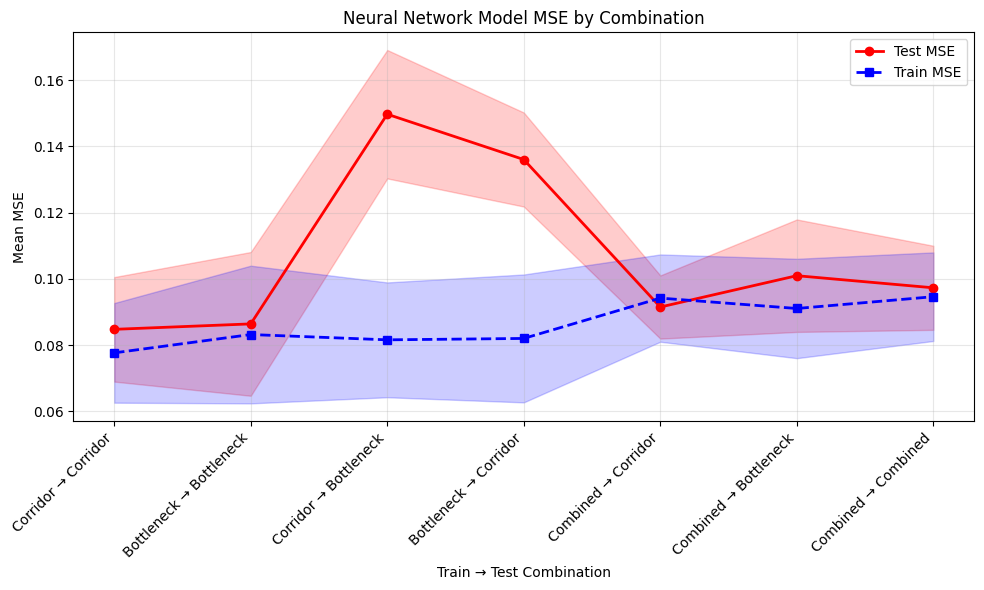

In [ ]:
import matplotlib.pyplot as plt


# Prepare data for scatter plot
test_mse = nn_results_df["Mean MSE Test"].values
test_mse_std = nn_results_df["Std MSE Test"].values
train_mse = nn_results_df["Mean MSE Train"].values
train_mse_std = nn_results_df["Std MSE Train"].values

nn_labels = (
    nn_results_df["Train Dataset"] + " → " + nn_results_df["Test Dataset"]
)
x = np.arange(len(nn_labels))

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot test MSE with error fill
ax.plot(
    x, test_mse, "o-", color="red", label="Test MSE", linewidth=2, markersize=6
)
ax.fill_between(
    x, test_mse - test_mse_std, test_mse + test_mse_std, color="red", alpha=0.2
)

# Plot train MSE with error fill
ax.plot(
    x,
    train_mse,
    "s--",
    color="blue",
    label="Train MSE",
    linewidth=2,
    markersize=6,
)
ax.fill_between(
    x,
    train_mse - train_mse_std,
    train_mse + train_mse_std,
    color="blue",
    alpha=0.2,
)

# Aesthetics
ax.set_xlabel("Train → Test Combination")
ax.set_ylabel("Mean MSE")
ax.set_title(
    "Neural Network Model MSE by Combination"
)
ax.set_xticks(x)
ax.set_xticklabels(nn_labels, rotation=45, ha="right")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

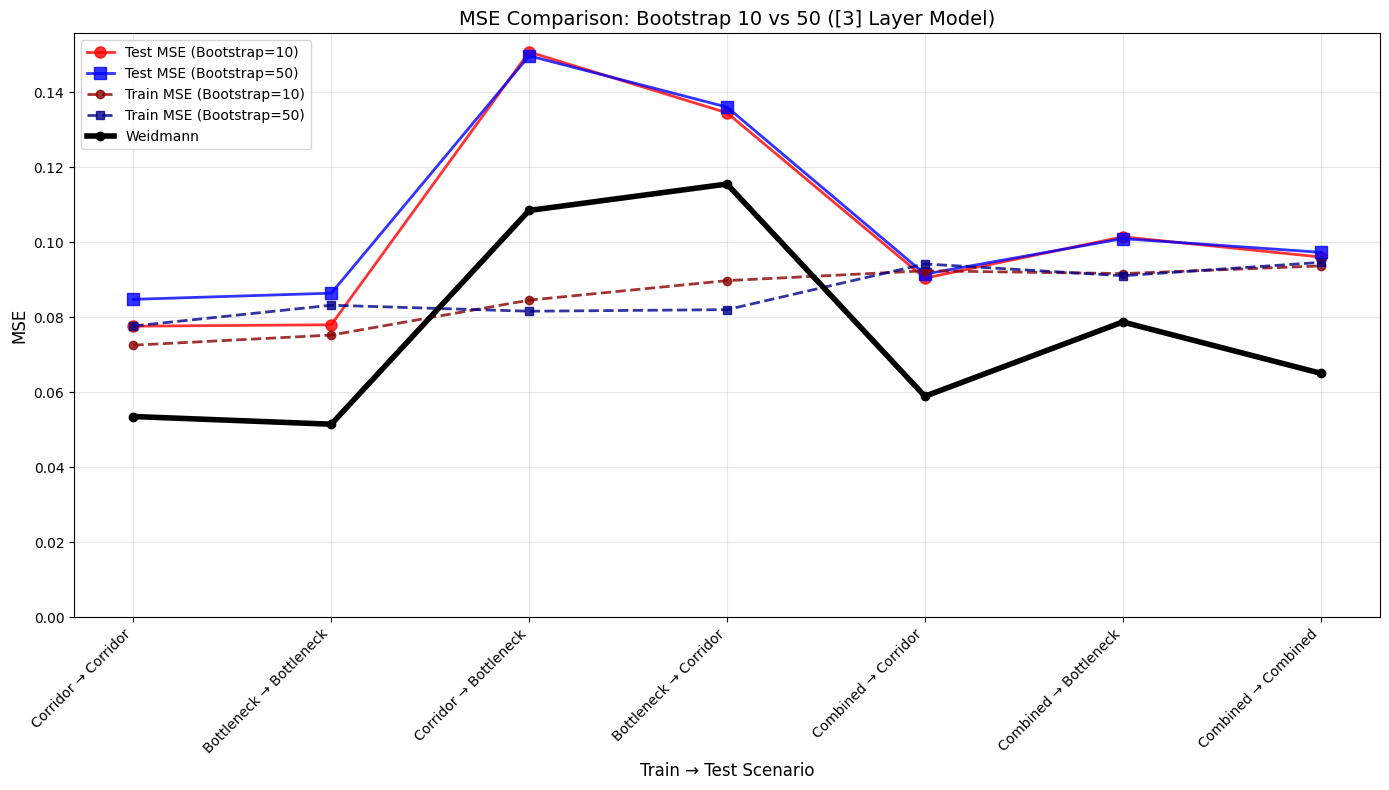

In [ ]:
# Bootstrap Comparison: 10 vs 50 iterations for [3] layer model
import matplotlib.pyplot as plt
import numpy as np

# Extract [3] layer results from multi-layer experiment (bootstrap=10)
layer_3_bootstrap_10 = results_df[results_df["Model"] == "[3]"].copy()

# Results from [3] layer experiment (bootstrap=50) are in nn_results_df
layer_3_bootstrap_50 = nn_results_df.copy()

# Create scenario labels for x-axis
scenario_labels = (
    layer_3_bootstrap_10["Train Dataset"] + " → " + layer_3_bootstrap_10["Test Dataset"]
).tolist()

# Extract MSE values
bootstrap_10_test_mse = layer_3_bootstrap_10["Mean MSE Test"].values
bootstrap_10_test_std = layer_3_bootstrap_10["Std MSE Test"].values
bootstrap_10_train_mse = layer_3_bootstrap_10["Mean MSE Train"].values
bootstrap_10_train_std = layer_3_bootstrap_10["Std MSE Train"].values

bootstrap_50_test_mse = layer_3_bootstrap_50["Mean MSE Test"].values
bootstrap_50_test_std = layer_3_bootstrap_50["Std MSE Test"].values
bootstrap_50_train_mse = layer_3_bootstrap_50["Mean MSE Train"].values
bootstrap_50_train_std = layer_3_bootstrap_50["Std MSE Train"].values

# Create single combined plot with all MSE comparisons
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# X positions for plotting
x_pos = np.arange(len(scenario_labels))

# Plot Test MSE - Bootstrap=10
ax.plot(x_pos, bootstrap_10_test_mse, 'o-', color='red', 
        label='Test MSE (Bootstrap=10)', linewidth=2, markersize=8, alpha=0.8)

# Plot Test MSE - Bootstrap=50
ax.plot(x_pos, bootstrap_50_test_mse, 's-', color='blue', 
        label='Test MSE (Bootstrap=50)', linewidth=2, markersize=8, alpha=0.8)


# Plot Train MSE - Bootstrap=10
ax.plot(x_pos, bootstrap_10_train_mse, 'o--', color='darkred', 
        label='Train MSE (Bootstrap=10)', linewidth=2, markersize=6, alpha=0.8)

# Plot Train MSE - Bootstrap=50
ax.plot(x_pos, bootstrap_50_train_mse, 's--', color='darkblue', 
        label='Train MSE (Bootstrap=50)', linewidth=2, markersize=6, alpha=0.8)

ax.plot(
    x_pos,
    mse_values,
    "o-",
    color="black",
    label="Weidmann",
    linewidth=4,
    markersize=6,
)

ax.set_xlabel('Train → Test Scenario', fontsize=12)
ax.set_ylabel('MSE', fontsize=12)
ax.set_title('MSE Comparison: Bootstrap 10 vs 50 ([3] Layer Model)', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(scenario_labels, rotation=45, ha='right')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Remove offset by setting y-axis to start from 0
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()
